# 胶囊网络(CapsNets) 

基于论文：[Dynamic Routing Between Capsules](https://arxiv.org/abs/1710.09829)，作者：Sara Sabour, Nicholas Frosst and Geoffrey E. Hinton (NIPS 2017)。

部分启发来自于Huadong Liao的实现[CapsNet-TensorFlow](https://github.com/naturomics/CapsNet-Tensorflow)

# 简介

观看 [视频](https://youtu.be/pPN8d0E3900)来理解胶囊网络背后的关键想法（大家可能看不到，因为youtube被墙了）：

In [157]:
from IPython.display import HTML
HTML("""<iframe width="560" height="315" src="https://www.youtube.com/embed/pPN8d0E3900" frameborder="0" allowfullscreen></iframe>""")

你或许也需要观看[视频](https://youtu.be/2Kawrd5szHE)，其展示了这个notebook的难点（大家可能看不到，因为youtube被墙了）：

In [158]:
HTML("""<iframe width="560" height="315" src="https://www.youtube.com/embed/2Kawrd5szHE" frameborder="0" allowfullscreen></iframe>""")

# Imports

为了绘制好看的图：

In [79]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

我们会用到 NumPy 和 TensorFlow：

In [80]:
import numpy as np
import tensorflow as tf

# 可重复性

为了能够在不重新启动Jupyter Notebook Kernel的情况下重新运行本notebook，我们需要重置默认的计算图。

In [81]:
tf.reset_default_graph()

设置随机种子，以便于本notebook总是可以输出相同的输出：

In [82]:
np.random.seed(42)
tf.set_random_seed(42)

# 装载MNIST

是的，我知道，又是MNIST。但我们希望这个极具威力的想法可以工作在更大的数据集上，时间会说明一切。（译注：因为是Hinton吗，因为他老是对;-)？）

In [83]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


让我们看一下这些手写数字图像是什么样的：

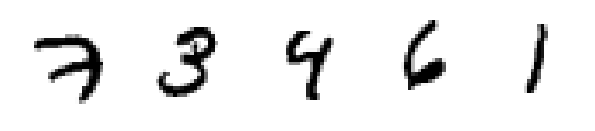

In [84]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

以及相应的标签：

In [85]:
mnist.train.labels[:n_samples]

array([7, 3, 4, 6, 1], dtype=uint8)

现在让我们建立一个胶囊网络来区分这些图像。这里有一个其总体的架构，享受一下ASCII字符的艺术吧! ;-)
注意：为了可读性，我摒弃了两种箭头：标签 → 掩盖，以及 输入的图像 → 重新构造损失。

```
                            损 失
                              ↑
                    ┌─────────┴─────────┐
          标 签 → 边 际 损 失     重 新 构 造 损 失
                    ↑                   ↑
                  模 长               解 码 器
                    ↑                   ↑ 
             数 字 胶 囊 们  ────遮 盖─────┘
               ↖↑↗ ↖↑↗ ↖↑↗
                 主 胶 囊 们
                    ↑      
               输 入 的 图 像
```

我们打算从底层开始构建该计算图，然后逐步上移，左侧优先。让我们开始！

# 输入图像

让我们通过为输入图像创建一个占位符作为起步，该输入图像具有28×28个像素，1个颜色通道=灰度。

In [86]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")

# 主胶囊

第一层由32个特征映射组成，每个特征映射为6$\times$6个胶囊，其中每个胶囊输出8维的激活向量：

In [87]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 主胶囊们
caps1_n_dims = 8

为了计算它们的输出，我们首先应用两个常规的卷积层：

In [88]:
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 个卷积滤波器
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

In [89]:
conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)

注意：由于我们使用一个尺寸为9的核，并且没有使用填充（出于某种原因，这就是`"valid"`的含义），该图像每经历一个卷积层就会缩减 $9-1=8$ 个像素（从 $28\times 28$ 到 $20 \times 20$，再从 $20\times 20$ 到 $12\times 12$），并且由于在第二个卷积层中使用了大小为2的步幅，那么该图像的大小就被除以2。这就是为什么我们最后会得到 $6\times 6$ 的特征映射（feature map）。

接着，我们重塑该输出以获得一组8D向量，用来表示主胶囊的输出。`conv2`的输出是一个数组，包含对于每个实例都有32×8=256个特征映射（feature map），其中每个特征映射为6×6。所以该输出的形状为 (_batch size_, 6, 6, 256)。我们想要把256分到32个8维向量中，可以通过使用重塑 (_batch size_, 6, 6, 32, 8)来达到目的。然而，由于首个胶囊层会被完全连接到下一个胶囊层，那么我们就可以简单地把它扁平成6×6的网格。这意味着我们只需要把它重塑成 (_batch size_, 6×6×32, 8) 即可。

In [90]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")

现在我们需要压缩这些向量。让我们来定义`squash()`函数，基于论文中的公式（1）：

$\operatorname{squash}(\mathbf{s}) = \dfrac{\|\mathbf{s}\|^2}{1 + \|\mathbf{s}\|^2} \dfrac{\mathbf{s}}{\|\mathbf{s}\|}$

该`squash()`函数将会压缩所有的向量到给定的数组中，沿给定轴（默认情况为最后一个轴）。

**当心**，这里有一个很讨厌的bug在等着你：当 $\|\mathbf{s}\|=0$时，$\|\mathbf{s}\|$ 为 undefined，这让我们不能直接使用 `tf.norm()`，否则会在训练过程中失败：如果一个向量为0，那么梯度就会是 `nan`，所以当优化器更新变量时，这些变量也会变为 `nan`，从那个时刻起，你就止步在 `nan` 那里了。解决的方法是手工实现norm，在计算的时候加上一个很小的值 epsilon：$\|\mathbf{s}\| \approx \sqrt{\sum\limits_i{{s_i}^2}\,\,+ \epsilon}$

In [91]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

现在让我们应用这个函数以获得每个主胶囊$\mathbf{u}_i$的输出：

In [92]:
caps1_output = squash(caps1_raw, name="caps1_output")

太棒了！我们有了首个胶囊层的输出了。不是很难，对吗？然后，计算下一层才是真正乐趣的开始（译注：好戏刚刚开始）。

# 数字胶囊们

要计算数字胶囊们的输出，我们必须首先计算预测的输出向量（每个对应一个主胶囊/数字胶囊的对）。接着，我们就可以通过协议算法来运行路由。

## 计算预测输出向量

该数字胶囊层包含10个胶囊（每个代表一个数字），每个胶囊16维：

In [93]:
caps2_n_caps = 10
caps2_n_dims = 16

对于在第一层里的每个胶囊 $i$，我们会在第二层中预测出每个胶囊 $j$ 的输出。为此，我们需要一个变换矩阵 $\mathbf{W}_{i,j}$（每一对就是胶囊($i$, $j$) 中的一个），接着我们就可以计算预测的输出$\hat{\mathbf{u}}_{j|i} = \mathbf{W}_{i,j} \, \mathbf{u}_i$（论文中的公式（2）的右半部分）。由于我们想要将8维向量变形为16维向量，因此每个变换向量$\mathbf{W}_{i,j}$必须具备(16, 8)形状。

要为每对胶囊 ($i$, $j$) 计算 $\hat{\mathbf{u}}_{j|i}$，我们会利用 `tf.matmul()` 函数的一个特点：你可能知道它可以让你进行两个矩阵相乘，但你可能不知道它可以让你进行更高维度的数组相乘。它将这些数组视作为数组矩阵，并且它会执行每项的矩阵相乘。例如，设有两个4D数组，每个包含2×3网格的矩阵。第一个包含矩阵为：$\mathbf{A}, \mathbf{B}, \mathbf{C}, \mathbf{D}, \mathbf{E}, \mathbf{F}$，第二个包含矩阵为：$\mathbf{G}, \mathbf{H}, \mathbf{I}, \mathbf{J}, \mathbf{K}, \mathbf{L}$。如果你使用 `tf.matmul`函数 对这两个4D数组进行相乘，你就会得到：

$
\pmatrix{
\mathbf{A} & \mathbf{B} & \mathbf{C} \\
\mathbf{D} & \mathbf{E} & \mathbf{F}
} \times
\pmatrix{
\mathbf{G} & \mathbf{H} & \mathbf{I} \\
\mathbf{J} & \mathbf{K} & \mathbf{L}
} = \pmatrix{
\mathbf{AG} & \mathbf{BH} & \mathbf{CI} \\
\mathbf{DJ} & \mathbf{EK} & \mathbf{FL}
}
$

我们可以把这个函数用来计算每对胶囊 ($i$, $j$) 的 $\hat{\mathbf{u}}_{j|i}$，就像这样（回忆一下，有 6×6×32=1152 个胶囊在第一层，还有10个在第二层）：

$
\pmatrix{
  \mathbf{W}_{1,1} & \mathbf{W}_{1,2} & \cdots & \mathbf{W}_{1,10} \\
  \mathbf{W}_{2,1} & \mathbf{W}_{2,2} & \cdots & \mathbf{W}_{2,10} \\
  \vdots & \vdots & \ddots & \vdots \\
  \mathbf{W}_{1152,1} & \mathbf{W}_{1152,2} & \cdots & \mathbf{W}_{1152,10}
} \times
\pmatrix{
  \mathbf{u}_1 & \mathbf{u}_1 & \cdots & \mathbf{u}_1 \\
  \mathbf{u}_2 & \mathbf{u}_2 & \cdots & \mathbf{u}_2 \\
  \vdots & \vdots & \ddots & \vdots \\
  \mathbf{u}_{1152} & \mathbf{u}_{1152} & \cdots & \mathbf{u}_{1152}
}
=
\pmatrix{
\hat{\mathbf{u}}_{1|1} & \hat{\mathbf{u}}_{2|1} & \cdots & \hat{\mathbf{u}}_{10|1} \\
\hat{\mathbf{u}}_{1|2} & \hat{\mathbf{u}}_{2|2} & \cdots & \hat{\mathbf{u}}_{10|2} \\
\vdots & \vdots & \ddots & \vdots \\
\hat{\mathbf{u}}_{1|1152} & \hat{\mathbf{u}}_{2|1152} & \cdots & \hat{\mathbf{u}}_{10|1152}
}
$


第一个数组的形状为 (1152, 10, 16, 8)，第二个数组的形状为 (1152, 10, 8, 1)。注意到第二个数组必须包含10个对于向量$\mathbf{u}_1$ 到 $\mathbf{u}_{1152}$ 的完全拷贝。为了要创建这样的数组，我们将使用好用的 `tf.tile()` 函数，它可以让你创建包含很多基数组拷贝的数组，并且根据你想要的进行平铺。

哦，稍等！我们还忘了一个维度：_batch size（批量/批次的大小）_。假设我们要给胶囊网络提供50张图片，那么该网络需要同时作出这50张图片的预测。所以第一个数组的形状为 (50, 1152, 10, 16, 8)，而第二个数组的形状为 (50, 1152, 10, 8, 1)。第一层的胶囊实际上已经对于所有的50张图像作出预测，所以第二个数组没有问题，但对于第一个数组，我们需要使用 `tf.tile()` 让其具有50个拷贝的变换矩阵。

好了，让我们开始，创建一个可训练的变量，形状为 (1, 1152, 10, 16, 8) 可以用来持有所有的变换矩阵。第一个维度的大小为1，可以让这个数组更容易的平铺。我们使用标准差为0.1的常规分布，随机初始化这个变量。

In [94]:
init_sigma = 0.1

W_init = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

现在我们可以通过每个实例重复一次`W`来创建第一个数组：

In [95]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

就是这样！现在转到第二个数组。如前所述，我们需要创建一个数组，形状为 (_batch size_, 1152, 10, 8, 1)，包含第一层胶囊的输出，重复10次（一次一个数字，在第三个维度，即axis=2）。 `caps1_output` 数组的形状为 (_batch size_, 1152, 8)，所以我们首先需要展开两次来获得形状 (_batch size_, 1152, 1, 8, 1) 的数组，接着在第三维度重复它10次。

In [96]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")

让我们检查以下第一个数组的形状：

In [97]:
W_tiled

<tf.Tensor 'W_tiled:0' shape=(?, 1152, 10, 16, 8) dtype=float32>

很好，现在第二个：

In [98]:
caps1_output_tiled

<tf.Tensor 'caps1_output_tiled:0' shape=(?, 1152, 10, 8, 1) dtype=float32>

好！现在，为了要获得所有的预测好的输出向量 $\hat{\mathbf{u}}_{j|i}$，我们只需要将这两个数组使用`tf.malmul()`函数进行相乘，就像前面解释的那样：

In [99]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

让我们检查一下形状：

In [100]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

非常好，对于在该批次（我们还不知道批次的大小，使用 "?" 替代）中的每个实例以及对于每对第一和第二层的胶囊（1152×10），我们都有一个16D预测的输出列向量 (16×1)。我们已经准备好应用 根据协议算法的路由 了！

## 根据协议的路由

首先，让我们初始化原始的路由权重 $b_{i,j}$ 到0:

In [101]:
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")

我们马上将会看到为什么我们需要最后两维大小为1的维度。

### 第一轮

首先，让我们应用 sofmax 函数来计算路由权重，$\mathbf{c}_{i} = \operatorname{softmax}(\mathbf{b}_i)$ （论文中的公式（3））：

In [102]:
routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")

现在让我们为每个第二层胶囊计算其预测输出向量的加权，$\mathbf{s}_j = \sum\limits_{i}{c_{i,j}\hat{\mathbf{u}}_{j|i}}$ （论文公式（2）的左半部分）：

In [103]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True,
                             name="weighted_sum")

这里有几个重要的细节需要注意：
* 要执行元素级别矩阵相乘（也称为Hadamard积，记作$\circ$），我们需要使用`tf.multiply()` 函数。它要求  `routing_weights` 和 `caps2_predicted` 具有相同的秩，这就是为什么前面我们在 `routing_weights` 上添加了两个额外的维度。
* `routing_weights`的形状为 (_batch size_, 1152, 10, 1, 1) 而 `caps2_predicted` 的形状为 (_batch size_, 1152, 10, 16, 1)。由于它们在第四个维度上不匹配（1 _vs_ 16），`tf.multiply()` 自动地在 `routing_weights` 该维度上 _广播_ 了16次。如果你不熟悉广播，这里有一个简单的例子，也许可以帮上忙：

  $ \pmatrix{1 & 2 & 3 \\ 4 & 5 & 6} \circ \pmatrix{10 & 100 & 1000} = \pmatrix{1 & 2 & 3 \\ 4 & 5 & 6} \circ \pmatrix{10 & 100 & 1000 \\ 10 & 100 & 1000} = \pmatrix{10 & 200 & 3000 \\ 40 & 500 & 6000} $

最后，让我们应用squash函数到在协议算法的第一次迭代迭代结束时获取第二层胶囊的输出上，$\mathbf{v}_j = \operatorname{squash}(\mathbf{s}_j)$：

In [104]:
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")

In [105]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

好！我们对于每个实例有了10个16D输出向量，就像我们期待的那样。

### 第二轮

首先，让我们衡量一下，每个预测向量 $\hat{\mathbf{u}}_{j|i}$ 对于实际输出向量 $\mathbf{v}_j$ 之间到底有多接近，这是通过它们的标量乘积 $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$来完成的。

* 快速数学上的提示：如果 $\vec{a}$ and $\vec{b}$ 是长度相等的向量，并且 $\mathbf{a}$ 和 $\mathbf{b}$ 是相应的列向量（如，只有一列的矩阵），那么 $\mathbf{a}^T \mathbf{b}$ （即 $\mathbf{a}$的转置和 $\mathbf{b}$的矩阵相乘）为一个1×1的矩阵，包含两个向量$\vec{a}\cdot\vec{b}$的标量积。在机器学习中，我们通常将向量表示为列向量，所以当我们探讨关于计算标量积 $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$的时候，其实意味着计算 ${\hat{\mathbf{u}}_{j|i}}^T \mathbf{v}_j$。

由于我们需要对每个实例和每个第一和第二层的胶囊对$(i, j)$，计算标量积 $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ ，我们将再次利用`tf.matmul()`可以同时计算多个矩阵相乘的特点。这就要求使用 `tf.tile()`来使得所有维度都匹配（除了倒数第二个），就像我们之前所作的那样。所以让我们查看`caps2_predicted`的形状，因为它持有对每个实例和每个胶囊对的所有预测输出向量$\hat{\mathbf{u}}_{j|i}$。

In [106]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

现在让我们查看 `caps2_output_round_1` 的形状，它有10个输出向量，每个16D，对应每个实例：

In [107]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

为了让这些形状相匹配，我们只需要在第二个维度平铺 `caps2_output_round_1` 1152次（一次一个主胶囊）：

In [108]:
caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")

现在我们已经准备好可以调用 `tf.matmul()`（注意还需要告知它在第一个数组中的矩阵进行转置，让${\hat{\mathbf{u}}_{j|i}}^T$ 来替代 $\hat{\mathbf{u}}_{j|i}$）：

In [109]:
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")

我们现在可以通过对于刚计算的标量积$\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$进行简单相加，来进行原始路由权重 $b_{i,j}$ 的更新：$b_{i,j} \gets b_{i,j} + \hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ （参见论文过程1中第7步）

In [110]:
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")

第二轮的其余部分和第一轮相同：

In [111]:
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        dim=2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")

我们可以继续更多轮，只需要重复第二轮中相同的步骤，但为了保持简洁，我们就到这里：

In [112]:
caps2_output = caps2_output_round_2

### 静态还是动态循环？

在上面的代码中，我们在TensorFlow计算图中为协调算法的每一轮路由创建了不同的操作。换句话说，它是一个静态循环。

当然，与其拷贝/粘贴这些代码几次，通常在python中，我们可以写一个 `for` 循环，但这不会改变这样一个事实，那就是在计算图中最后对于每个路由迭代都会有不同的操作。这其实是可接受的，因为我们通常不会具有超过5次路由迭代，所以计算图不会成长得太大。

然而，你可能更倾向于在TensorFlow计算图自身实现路由循环，而不是使用Python的`for`循环。为了要做到这点，将需要使用TensorFlow的 `tf.while_loop()` 函数。这种方式，所有的路由循环都可以重用在该计算图中的相同的操作，这被称为动态循环。

例如，这里是如何构建一个小循环用来计算1到100的平方和：

In [113]:
def condition(input, counter):
    return tf.less(counter, 100)

def loop_body(input, counter):
    output = tf.add(input, tf.square(counter))
    return output, tf.add(counter, 1)

with tf.name_scope("compute_sum_of_squares"):
    counter = tf.constant(1)
    sum_of_squares = tf.constant(0)

    result = tf.while_loop(condition, loop_body, [sum_of_squares, counter])
    

with tf.Session() as sess:
    print(sess.run(result))

(328350, 100)


如你所见， `tf.while_loop()` 函数期望的循环条件和循环体由两个函数来提供。这些函数仅会被TensorFlow调用一次，在构建计算图阶段，_不_ 在执行计算图的时候。 `tf.while_loop()` 函数将由 `condition()` 和 `loop_body()` 创建的计算图碎片同一些用来创建循环的额外操作缝制在一起。

还注意到在训练的过程中，TensorFlow将自动地通过循环处理反向传播，因此你不需要担心这些事情。

当然，我们也可以一行代码搞定！;)

In [ ]:
sum([i**2 for i in range(1, 100 + 1)])

开个玩笑，抛开缩减计算图的大小不说，使用动态循环而不是静态循环能够帮助减少很多的GPU RAM的使用（如果你使用GPU的话）。事实上，如果但调用 `tf.while_loop()` 函数时，你设置了 `swap_memory=True` ，TensorFlow会在每个循环的迭代上自动检查GPU RAM使用情况，并且它会照顾到在GPU和CPU之间swapping内存时的需求。既然CPU的内存便宜量又大，相对GPU RAM而言，这就很有意义了。

# 估算的分类概率（模长）

输出向量的模长代表了分类的概率，所以我们就可以使用`tf.norm()`来计算它们，但由于我们在讨论`squash`函数时看到的那样，可能会有风险，所以我们创建了自己的 `safe_norm()` 函数来进行替代：

In [114]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [115]:
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")

要预测每个实例的分类，我们只需要选择那个具有最高估算概率的就可以了。要做到这点，让我们通过使用 `tf.argmax()` 来达到我们的目的：

In [116]:
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

让我们检查一下 `y_proba_argmax` 的形状：

In [117]:
y_proba_argmax

<tf.Tensor 'y_proba_1:0' shape=(?, 1, 1) dtype=int64>

这正好是我们想要的：对于每一个实例，我们现在有了最长的输出向量的索引。让我们用 `tf.squeeze()` 来移除后两个大小为1的维度。这就给出了该胶囊网络对于每个实例的预测分类：

In [118]:
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

In [119]:
y_pred

<tf.Tensor 'y_pred:0' shape=(?,) dtype=int64>

好了，我们现在准备好开始定义训练操作，从损失开始。

# 标签

首先，我们将需要一个对于标签的占位符：

In [120]:
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

# 边际损失

论文使用了一个特殊的边际损失，来使得在每个图像中侦测多于两个以上的数字成为可能：

$ L_k = T_k \max(0, m^{+} - \|\mathbf{v}_k\|)^2 + \lambda (1 - T_k) \max(0, \|\mathbf{v}_k\| - m^{-})^2$

* $T_k$ 等于1，如果分类$k$的数字出现，否则为0.
* 在论文中，$m^{+} = 0.9$, $m^{-} = 0.1$，并且$\lambda = 0.5$
* 注意在视频15:47秒处有个错误：应该是最大化操作，而不是norms，被平方。不好意思。

In [121]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

既然 `y` 将包含数字分类，从0到9，要对于每个实例和每个分类获取 $T_k$ ，我们只需要使用 `tf.one_hot()` 函数即可：

In [122]:
T = tf.one_hot(y, depth=caps2_n_caps, name="T")

一个小例子应该可以说明这到底做了什么：

In [123]:
with tf.Session():
    print(T.eval(feed_dict={y: np.array([0, 1, 2, 3, 9])}))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


现在让我们对于每个输出胶囊和每个实例计算输出向量。首先，让我们验证 `caps2_output` 形状：

In [124]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

这些16D向量位于第二到最后的维度，因此让我们在 `axis=-2` 使用 `safe_norm()` 函数：

In [125]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

现在让我们计算 $\max(0, m^{+} - \|\mathbf{v}_k\|)^2$，并且重塑其结果以获得一个简单的具有形状(_batch size_, 10)的矩阵：

In [126]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                           name="present_error")

接下来让我们计算 $\max(0, \|\mathbf{v}_k\| - m^{-})^2$ 并且重塑成(_batch size_,10)：

In [127]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                          name="absent_error")

我们准备好为每个实例和每个数字计算损失：

In [128]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

现在我们可以把对于每个实例的数字损失进行相加($L_0 + L_1 + \cdots + L_9$)，并且在所有的实例中计算均值。这给予我们最后的边际损失：

In [129]:
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

# 重新构造

现在让我们添加一个解码器网络，其位于胶囊网络之上。它是一个常规的3层全连接神经网络，其将基于胶囊网络的输出，学习重新构建输入图像。这将强制胶囊网络保留所有需要重新构造数字的信息，贯穿整个网络。该约束正则化了模型：它减少了训练数据集过拟合的风险，并且它有助于泛化到新的数字。

## 遮盖

论文中提及了在训练的过程中，与其发送所有的胶囊网络的输出到解码器网络，不如仅发送与目标数字对应的胶囊输出向量。所有其余输出向量必须被遮盖掉。在推断的时候，我们必须遮盖所有输出向量，除了最长的那个。即，预测的数字相关的那个。你可以查看论文中的图2（视频中的18:15）：所有的输出向量都被遮盖掉了，除了那个重新构造目标的输出向量。

我们需要一个占位符来告诉TensorFlow，是否我们想要遮盖这些输出向量，根据标签 (`True`) 或 预测 (`False`, 默认)：

In [130]:
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

现在让我们使用 `tf.cond()` 来定义重新构造的目标，如果 `mask_with_labels` 为 `True` 就是标签 `y`，否则就是 `y_pred`。

In [131]:
reconstruction_targets = tf.cond(mask_with_labels, # 条件
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

注意到 `tf.cond()` 函数期望的是通过函数传递而来的if-True 和 if-False张量：这些函数会在计算图构造阶段（而非执行阶段）被仅调用一次，和`tf.while_loop()`类似。这可以允许TensorFlow添加必要操作，以此处理if-True 和 if-False 张量的条件评估。然而，在这里，张量 `y` 和 `y_pred` 已经在我们调用 `tf.cond()` 时被创建，不幸地是TensorFlow会认为 `y` 和 `y_pred` 是 `reconstruction_targets` 张量的依赖项。虽然，`reconstruction_targets` 张量最终是会计算出正确值，但是：
1. 无论何时，我们评估某个依赖于 `reconstruction_targets` 的张量，`y_pred` 张量也会被评估（即便 `mask_with_layers` 为 `True`）。这不是什么大问题，因为，在训练阶段计算`y_pred` 张量不会添加额外的开销，而且不管怎么样我们都需要它来计算边际损失。并且在测试中，如果我们做的是分类，我们就不需要重新构造，所以`reconstruction_grpha`根本不会被评估。
2. 我们总是需要为`y`占位符递送一个值（即使`mask_with_layers`为`False`）。这就有点讨厌了，当然我们可以传递一个空数组，因为TensorFlow无论如何都不会用到它（就是当检查依赖项的时候还不知道）。

现在我们有了重新构建的目标，让我们创建重新构建的遮盖。对于目标类型它应该为1.0，对于其他类型应该为0.0。为此我们就可以使用`tf.one_hot()`函数：

In [132]:
reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")

让我们检查一下 `reconstruction_mask`的形状：

In [133]:
reconstruction_mask

<tf.Tensor 'reconstruction_mask:0' shape=(?, 10) dtype=float32>

和 `caps2_output` 的形状比对一下：

In [134]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

嗯，它的形状是 (_batch size_, 1, 10, 16, 1)。我们想要将它和 `reconstruction_mask` 进行相乘，但 `reconstruction_mask`的形状是(_batch size_, 10)。我们必须对此进行reshape成 (_batch size_, 1, 10, 1, 1) 来满足相乘的要求：

In [135]:
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")

最终我们可以应用 遮盖 了！

In [136]:
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

In [137]:
caps2_output_masked

<tf.Tensor 'caps2_output_masked:0' shape=(?, 1, 10, 16, 1) dtype=float32>

最后还有一个重塑操作被用来扁平化解码器的输入：

In [138]:
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")

这给予我们一个形状是 (_batch size_, 160) 的数组：

In [139]:
decoder_input

<tf.Tensor 'decoder_input:0' shape=(?, 160) dtype=float32>

## 解码器

现在让我们来构建该解码器。它非常简单：两个密集（全连接）ReLU 层紧跟这一个密集输出sigmoid层：

In [140]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

In [141]:
with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")

## 重新构造的损失

现在让我们计算重新构造的损失。它不过是输入图像和重新构造过的图像的平方差。

In [142]:
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")

## 最终损失

最终损失为边际损失和重新构造损失（使用放大因子0.0005确保边际损失在训练过程中处于支配地位）的和：

In [143]:
alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

# 最后润色

## 精度

为了衡量模型的精度，我们需要计算实例被正确分类的数量。为此，我们可以简单地比较`y`和`y_pred`，并将比较结果的布尔值转换成float32（0.0代表False，1.0代表True），并且计算所有实例的均值：

In [144]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

## 训练操作

论文中提到作者使用Adam优化器，使用了TensorFlow的默认参数：

In [145]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

## 初始化和Saver

让我们来添加变量初始器，还要加一个 `Saver`：

In [146]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

还有... 我们已经完成了构造阶段！花点时间可以庆祝🎉一下。:)

# 训练

训练我们的胶囊网络是非常标准的。为了简化，我们不需要作任何花哨的超参调整、丢弃等，我们只是一遍又一遍运行训练操作，显示损失，并且在每个epoch结束的时候，根据验证集衡量一下精度，显示出来，并且保存模型，当然，验证损失是目前为止最低的模型才会被保存（这是一种基本的实现早停的方法，而不需要实际上打断训练的进程）。我们希望代码能够自释，但这里应该有几个细节值得注意：
* 如果某个checkpoint文件已经存在，那么它会被恢复（这可以让训练被打断，再从最新的checkpoint中进行恢复成为可能），
* 我们不要忘记在训练的时候传递`mask_with_labels=True`，
* 在测试的过程中，我们可以让`mask_with_labels`默认为`False`（但是我们仍然需要传递标签，因为它们在计算精度的时候会被用到），
* 通过 `mnist.train.next_batch()`装载的图片会被表示为类型 `float32` 数组，其形状为\[784\]，但输入的占位符`X`期望的是一个`float32`数组，其形状为 \[28, 28, 1\]，所以在我们把送到模型之前，必须把这些图像进行重塑，
* 我们在整个完整的验证集上对模型的损失和精度进行评估。为了能够看到进度和支持那些并没有太多RAM的系统，评估损失和精度的代码在一个批次上执行一次，并且最后再计算平均损失和平均精度。

*警告*：如果你没有GPU，训练将会非常漫长（至少几个小时）。当使用GPU，它应该对于每个epoch只需要几分钟（如，在NVidia GeForce GTX 1080Ti上只需要6分钟）。

In [147]:
n_epochs = 10
batch_size = 50
restore_checkpoint = True

n_iterations_per_epoch = mnist.train.num_examples // batch_size
n_iterations_validation = mnist.validation.num_examples // batch_size
best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            # 运行训练操作并且评估损失:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # 在每个epoch之后，
        # 衡量验证损失和精度：
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # 如果有进步就保存模型：
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Epoch: 1  Val accuracy: 98.9400%  Loss: 0.015190 (improved)
Epoch: 2  Val accuracy: 99.2000%  Loss: 0.010183 (improved)
Epoch: 3  Val accuracy: 99.3200%  Loss: 0.008860 (improved)
Epoch: 4  Val accuracy: 99.3000%  Loss: 0.007782 (improved)
Epoch: 5  Val accuracy: 99.2400%  Loss: 0.008245
Epoch: 6  Val accuracy: 99.3200%  Loss: 0.008094
Epoch: 7  Val accuracy: 99.3400%  Loss: 0.007472 (improved)
Epoch: 8  Val accuracy: 99.3800%  Loss: 0.007024 (improved)
Epoch: 9  Val accuracy: 99.2400%  Loss: 0.007232
Epoch: 10  Val accuracy: 99.3200%  Loss: 0.007789


我们在训练结束后，在验证集上达到了99.32%的精度，只用了5个epoches，看上去不错。现在让我们将模型运用到测试集上。

# 评估

In [148]:
n_iterations_test = mnist.test.num_examples // batch_size

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = mnist.test.next_batch(batch_size)
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

INFO:tensorflow:Restoring parameters from ./my_capsule_network
Final test accuracy: 99.2100%  Loss: 0.007933   


我们在测试集上达到了99.21%的精度。相当棒！

# 预测

现在让我们进行一些预测！首先从测试集确定一些图片，接着开始一个session，恢复已经训练好的模型，评估`cap2_output`来获得胶囊网络的输出向量，`decoder_output`来重新构造，用`y_pred`来获得类型预测：

In [149]:
n_samples = 5

sample_images = mnist.test.images[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

INFO:tensorflow:Restoring parameters from ./my_capsule_network


注意：我们传递的`y`使用了一个空的数组，不过TensorFlow并不会用到它，前面已经解释过了。

现在让我们把这些图片和它们的标签绘制出来，同时绘制出来的还有相应的重新构造和预测：

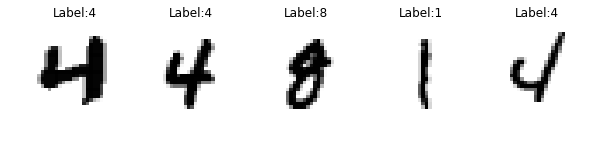

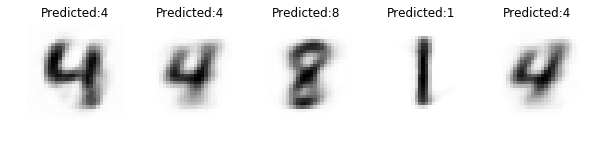

In [150]:
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(mnist.test.labels[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()


预测都正确，而且重新构造的图片看上去很棒。阿弥陀佛！

# 理解输出向量

让我们调整一下输出向量，对它们的姿态参数表示进行查看。

首先让我们检查`cap2_output_value` NumPy数组的形状：

In [151]:
caps2_output_value.shape

(5, 1, 10, 16, 1)

让我们创建一个函数，该函数在所有的输出向量里对于每个 16（维度）姿态参数进行调整。每个调整过的输出向量将和原来的输出向量相同，除了它的 姿态参数 中的一个会加上一个-0.5到0.5之间变动的值。默认的会有11个步数(-0.5, -0.4, ..., +0.4, +0.5)。这个函数会返回一个数组，其形状为(_调整过的姿态参数_=16, _步数_=11, _batch size_=5, 1, 10, 16, 1)：

In [152]:
def tweak_pose_parameters(output_vectors, min=-0.5, max=0.5, n_steps=11):
    steps = np.linspace(min, max, n_steps) # -0.25, -0.15, ..., +0.25
    pose_parameters = np.arange(caps2_n_dims) # 0, 1, ..., 15
    tweaks = np.zeros([caps2_n_dims, n_steps, 1, 1, 1, caps2_n_dims, 1])
    tweaks[pose_parameters, :, 0, 0, 0, pose_parameters, 0] = steps
    output_vectors_expanded = output_vectors[np.newaxis, np.newaxis]
    return tweaks + output_vectors_expanded

让我们计算所有的调整过的输出向量并且重塑结果到 (_parameters_×_steps_×_instances_, 1, 10, 16, 1) 以便于我们能够传递该数组到解码器中：

In [153]:
n_steps = 11

tweaked_vectors = tweak_pose_parameters(caps2_output_value, n_steps=n_steps)
tweaked_vectors_reshaped = tweaked_vectors.reshape(
    [-1, 1, caps2_n_caps, caps2_n_dims, 1])

现在让我们递送这些调整过的输出向量到解码器并且获得重新构造，它会产生：

In [154]:
tweak_labels = np.tile(mnist.test.labels[:n_samples], caps2_n_dims * n_steps)

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    decoder_output_value = sess.run(
            decoder_output,
            feed_dict={caps2_output: tweaked_vectors_reshaped,
                       mask_with_labels: True,
                       y: tweak_labels})

INFO:tensorflow:Restoring parameters from ./my_capsule_network


让我们重塑解码器的输出以便于我们能够在输出维度，调整步数，和实例之上进行迭代：

In [155]:
tweak_reconstructions = decoder_output_value.reshape(
        [caps2_n_dims, n_steps, n_samples, 28, 28])

最后，让我们绘制所有的重新构造，对于前三个输出维度，对于每个调整中的步数（列）和每个数字（行）：

Tweaking output dimension #0


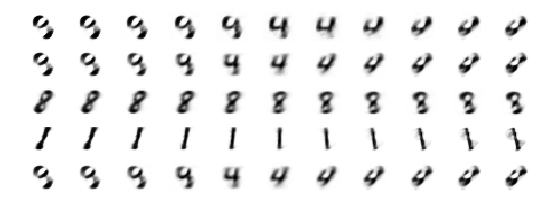

Tweaking output dimension #1


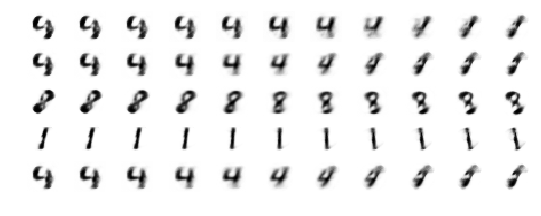

Tweaking output dimension #2


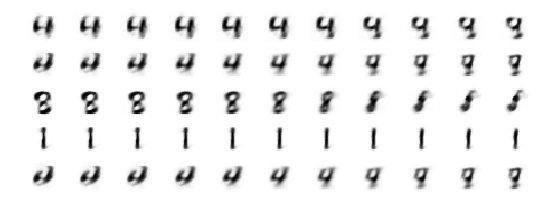

In [156]:
for dim in range(3):
    print("Tweaking output dimension #{}".format(dim))
    plt.figure(figsize=(n_steps / 1.2, n_samples / 1.5))
    for row in range(n_samples):
        for col in range(n_steps):
            plt.subplot(n_samples, n_steps, row * n_steps + col + 1)
            plt.imshow(tweak_reconstructions[dim, col, row], cmap="binary")
            plt.axis("off")
    plt.show()

# 小结

我试图让这个notebook中的代码尽量的扁平和线性，为了让大家容易跟上，当然在实践中大家可能想要包装这些代码成可重用的函数和类。例如，你可以尝试实现你自己的`PrimaryCapsuleLayer`，和`DeseRoutingCapsuleLayer` 类，其参数可以是胶囊的数量，路由迭代的数量，是使用动态循环还是静态循环，诸如此类。对于基于TensorFlow模块化的胶囊网络的实现，可以参考[CapsNet-TensorFlow](https://github.com/naturomics/CapsNet-Tensorflow) 项目。

这就是今天所有的内容，我希望你们喜欢这个notebook！